In [17]:
%load_ext aiida
%aiida

The aiida extension is already loaded. To reload it, use:
  %reload_ext aiida


Loaded AiiDA DB environment - profile name: presto.

In [2]:
import pathlib
import pandas as pd
import json
import numpy as np
from itertools import combinations

In [3]:
data_path = pathlib.Path('/Users/treents/project/aiida-cwf/data')

In [4]:
def update_data(data: dict, key: tuple, new_data: dict):
    merged_data = {k: v for k, v in data.items()}
    for k, v in new_data.items():
        if k in merged_data[key]:
            raise ValueError(f'Key {k} already exists in data[{key}]')
        merged_data[key][k] = v
    return merged_data

In [5]:
codes = ['fleur', 'wien2k', 'sirius-cp2k']

indices = []
df_central_volumes = []
all_codes_central_volumes = {}

data_file_to_skip = [
    'results-unaries-verification-cp2k-PBE-v1.json'
]

for code in codes:
    for data_file in (data_path / code / 'for central volumes').iterdir():
        if data_file.name in data_file_to_skip:
            continue
        
        if 'pbesol' in data_file.name.lower():
            functional = 'pbesol'
        elif 'pbe' in data_file.name.lower():
            functional = 'pbe'
        elif 'lda' in data_file.name.lower():
            functional = 'lda'
            if code == 'fleur' and 'VWN' in data_file.name:
                continue
        else:
            continue
        
        if 'unaries' in data_file.name:
            unaries_oxides = 'unaries'
        elif 'oxides':
            unaries_oxides = 'oxides'
        
        try:
            with open(data_file, 'r') as f:
                data = json.load(f)
        except:
            continue
        central_volumes = {
            k: v['min_volume'] if not (unaries_oxides == 'oxides' and k in ['O-XO', 'O-X2O5'] and code == 'wien2k') else 1 / 2 * v['min_volume']
            for k,v in data['BM_fit_data'].items() if v is not None}
        # indices.append((code, unaries_oxides, functional, data_file.name))
        key = (code, unaries_oxides, functional, data_file.name)
        all_codes_central_volumes.setdefault(key, {}).update(central_volumes)
        indices.append(key)
        print(data_file.name, len(central_volumes), sep=':\t')
        # df_central_volumes.append(pd.Series(central_volumes.values(), index=central_volumes.keys()))
        # pd.DataFrame.from_dict(data, orient='index').to_csv(data_file.with_name(f'{data_file.stem}_{functional}.csv'))
# df_central_volumes = pd.concat(
#     df_central_volumes, 
#     keys=indices, 
#     names=['code', 'group', 'functional', 'filename'], 
#     axis=1
#     ).sort_index(axis=1)
df_central_volumes = pd.DataFrame.from_dict(all_codes_central_volumes, orient='columns').sort_index(axis=1)

results-oxides-LDA-PW92-fleur_centralVolume.json:	618
results-unaries-actinides-v01-pbe-fleur_centralVolume.json:	28
results-unaries-LDA-PW92-fleur_centralVolume.json:	412
results-unaries-PBEsol-fleur_centralVolume.json:	412
results-oxides-actinides-v01-pbe-fleur_centralVolume.json:	42
results-oxides-PBEsol-fleur_centralVolume.json:	618
oxides_pbe_prec3.json:	48
unaries_prec3_lda.json:	412
unaries_prec3_pbesol.json:	412
results-oxides-PBEsol-WIEN2k.json:	618
unaries_prec3_pbe.json:	32
results-oxides-lda-v1-wien2k.json:	618
CentralVolume-PBE-v1-cp2k.json:	618
results-unaries-verification-cp2k-LDA-v4.json:	408
CentralVolume-oxides-LDA-cp2k.json:	618
results-unaries-verification-PBE-v1-cp2k.json:	404
CentralVolume-oxides-PBEsol-cp2k.json:	618
results-unaries-verification-cp2k-PBEsol-v4.json:	408


In [6]:
df_central_volumes

fleur  \
                                                       oxides   
                                                          lda   
             results-oxides-LDA-PW92-fleur_centralVolume.json   
Ac-X2O                                              73.518370   
Ac-X2O3                                            191.439599   
Ac-X2O5                                            191.702472   
Ac-XO                                               36.451587   
Ac-XO2                                              49.295822   
...                                                       ...   
Zn-X/SC                                                   NaN   
Zr-X/BCC                                                  NaN   
Zr-X/Diamond                                              NaN   
Zr-X/FCC                                                  NaN   
Zr-X/SC                                                   NaN   

                                                                        \
                                                                         
                                                                   pbe   
             results-oxides-actinides-v01-pbe-fleur_centralVolume.json   
Ac-X2O                                                      NaN          
Ac-X2O3                                                     NaN          
Ac-X2O5                                                     NaN          
Ac-XO                                                       NaN          
Ac-XO2                                                      NaN          
...                                                         ...          
Zn-X/SC                                                     NaN          
Zr-X/BCC                                                    NaN          
Zr-X/Diamond                                                NaN          
Zr-X/FCC                                                    NaN          
Zr-X/SC                                                     NaN          

                                                             \
                                                              
                                                     pbesol   
             results-oxides-PBEsol-fleur_centralVolume.json   
Ac-X2O                                            75.682241   
Ac-X2O3                                          195.973852   
Ac-X2O5                                          197.660555   
Ac-XO                                             37.328918   
Ac-XO2                                            50.677008   
...                                                     ...   
Zn-X/SC                                                 NaN   
Zr-X/BCC                                                NaN   
Zr-X/Diamond                                            NaN   
Zr-X/FCC                                                NaN   
Zr-X/SC                                                 NaN   

                                                                \
                                                       unaries   
                                                           lda   
             results-unaries-LDA-PW92-fleur_centralVolume.json   
Ac-X2O                                                     NaN   
Ac-X2O3                                                    NaN   
Ac-X2O5                                                    NaN   
Ac-XO                                                      NaN   
Ac-XO2                                                     NaN   
...                                                        ...   
Zn-X/SC                                              16.066104   
Zr-X/BCC                                             21.113246   
Zr-X/Diamond                                         55.422873   
Zr-X/FCC                                             21.567404   
Zr-X/SC                                              22.764560   

                                

In [7]:
code_differences = {}
for ((code1, group1, functional1, file1), (code2, group2, functional2, file2)) in combinations(df_central_volumes.columns, 2):
    df1 = df_central_volumes[(code1, group1, functional1, file1)]
    df2 = df_central_volumes[(code2, group2, functional2, file2)]
    if df1.shape[0] != df2.shape[0] or functional1 != functional2 or code1 == code2 or group1 != group2:
        if df1.shape[0] != df2.shape[0]:
            print(code1, code2, group1, group2, functional1, functional2, file1, file2)
        continue
    
    if (code1 == 'sirius_cp2k' and 'v3' not in file1) or (code2 == 'sirius_cp2k' and 'v3' not in file2):
        # continue
        pass
        
    
    code_differences[(code1, code2, group1, functional1, f'{file1} - {file2}')] = (df1 - df2) / df1 * 100
    # if ((df1 - df2) / df1).isna().mean() == 1.0:
    #     print(code1, code2, group1, group2, functional1, functional2, file1, file2)
    #     print(df1, df2)
    #     df1_to_check = df1
    #     df2_to_check = df2
    # print(f'{code1} {functional1} vs {code2} {functional2}')
    # print(np.corrcoef(df1, df2)[0,1])

In [8]:
df_code_differences = pd.DataFrame(code_differences).sort_index(axis=1).round(3)
df_code_differences.columns = pd.MultiIndex.from_tuples(
    [(' - '.join(col[:2]).strip(), *col[2:]) for col in df_code_differences.columns.values]
)
df_code_differences = df_code_differences.loc[
    df_code_differences.abs().sum(axis=1).sort_values(ascending=False).index
]

In [9]:
# mean_lda = df_central_volumes.loc(axis=1)[:, 'lda'].mean(axis=1)
# median_lda = df_central_volumes.loc(axis=1)[:, 'lda'].median(axis=1)
# df_central_volumes[('mean', 'lda', '')] = mean_lda
# df_central_volumes[('median', 'lda', '')] = median_lda

In [10]:
# relative_differences = df_central_volumes.loc(axis=1)[:, 'lda'].sub(
#     df_central_volumes[('median', 'lda', '')].values, axis=0
#     ).div(df_central_volumes.loc(axis=1)[:, 'lda']).mul(100)#.drop('mean', axis=1)

In [11]:
# relative_differences

In [12]:
# df_relative_differences = relative_differences.abs().sort_values(
#     by=('sirius_cp2k', 'lda', ''), axis=0, ascending=False
#     ).drop([('mean', 'lda', ''), ('median', 'lda', '')], axis=1)

In [13]:
def highlight_cells(val):
    """
    Return a background color based on the cell value.
    """
    if -1 <= val <= 1:
        return 'background-color: lightgreen'  # Within ±1
    elif -2 <= val < -1 or 1 < val <= 2:
        return 'background-color: #FFFF33'  # Within ±2 but outside ±1
    elif pd.isna(val):
        return 'background-color: #999999'
    else:
        return 'background-color: #CC3333'  # Outside ±2
    


In [16]:
df_code_differences_unaries = df_code_differences.xs('unaries', level=1, axis=1).copy().dropna(how='all')
df_code_differences_oxides = df_code_differences.xs('oxides', level=1, axis=1).copy().dropna(how='all')

styled_df_unaries = df_code_differences_unaries.sort_index().round(4).style.map(highlight_cells)
styled_df_oxides = df_code_differences_oxides.sort_index().round(4).style.map(highlight_cells)

In [16]:
version = 'v5'

styled_df_unaries.to_excel(f"central_volumes_unaries_differences_{version}.xlsx", engine="openpyxl")
styled_df_oxides.to_excel(f"central_volumes_oxides_differences_{version}.xlsx", engine="openpyxl")

In [16]:
df_code_differences_unaries.abs().mean()

fleur - sirius_cp2k   lda     results-unaries-LDA-PW92-fleur_centralVolume.json - results-unaries-verification-cp2k-LDA-v4.json             0.055262
                      pbe     results-unaries-actinides-v01-pbe-fleur_centralVolume.json - results-unaries-verification-PBE-v1-cp2k.json    0.295292
                      pbesol  results-unaries-PBEsol-fleur_centralVolume.json - results-unaries-verification-cp2k-PBEsol-v4.json            0.048919
fleur - wien2k        lda     results-unaries-LDA-PW92-fleur_centralVolume.json - unaries_prec3_lda.json                                    0.037502
                      pbe     results-unaries-actinides-v01-pbe-fleur_centralVolume.json - unaries_prec3_pbe.json                           0.044893
                      pbesol  results-unaries-PBEsol-fleur_centralVolume.json - unaries_prec3_pbesol.json                                   0.038823
sirius_cp2k - wien2k  lda     results-unaries-verification-cp2k-LDA-v4.json - unaries_prec3_lda.json      

In [17]:
df_code_differences_unaries.abs().mean()

fleur - sirius-cp2k   lda     results-unaries-LDA-PW92-fleur_centralVolume.json - results-unaries-verification-cp2k-LDA-v4.json             0.055262
                      pbe     results-unaries-actinides-v01-pbe-fleur_centralVolume.json - results-unaries-verification-PBE-v1-cp2k.json    0.295292
                      pbesol  results-unaries-PBEsol-fleur_centralVolume.json - results-unaries-verification-cp2k-PBEsol-v4.json            0.048919
fleur - wien2k        lda     results-unaries-LDA-PW92-fleur_centralVolume.json - unaries_prec3_lda.json                                    0.037502
                      pbe     results-unaries-actinides-v01-pbe-fleur_centralVolume.json - unaries_prec3_pbe.json                           0.044893
                      pbesol  results-unaries-PBEsol-fleur_centralVolume.json - unaries_prec3_pbesol.json                                   0.038823
sirius-cp2k - wien2k  lda     results-unaries-verification-cp2k-LDA-v4.json - unaries_prec3_lda.json      

In [17]:
df_code_differences_unaries

fleur - sirius_cp2k  \
                                                                                                           lda   
             results-unaries-LDA-PW92-fleur_centralVolume.json - results-unaries-verification-cp2k-LDA-v4.json   
Th-X/Diamond                                              1.751                                                  
Md-X/SC                                                  -0.299                                                  
Md-X/BCC                                                 -0.330                                                  
Fm-X/FCC                                                 -0.221                                                  
Fm-X/BCC                                                 -0.232                                                  
...                                                         ...                                                  
Y-X/BCC                                                   0.004                                                  
Ta-X/BCC                                                 -0.002                                                  
Lu-X/BCC                                                  0.000                                                  
Kr-X/FCC                                                  0.006                                                  
K-X/BCC                                                   0.007                                                  

                                                                                                                         \
                                                                                                                    pbe   
             results-unaries-actinides-v01-pbe-fleur_centralVolume.json - results-unaries-verification-PBE-v1-cp2k.json   
Th-X/Diamond                                                NaN                                                           
Md-X/SC                                                  -0.764                                                           
Md-X/BCC                                                 -0.442                                                           
Fm-X/FCC                                                 -0.570                                                           
Fm-X/BCC                                                 -0.599                                                           
...                                                         ...                                                           
Y-X/BCC                                                     NaN                                                           
Ta-X/BCC                                                    NaN                                                           
Lu-X/BCC                                                    NaN                                                           
Kr-X/FCC                                                    NaN                                                           
K-X/BCC                                                     NaN                                                           

                                                                                                                 \
                                                                                                         pbesol   
             results-unaries-PBEsol-fleur_centralVolume.json - results-unaries-verification-cp2k-PBEsol-v4.json   
Th-X/Diamond                                              0.090                                                   
Md-X/SC                                                  -0.505                                                   
Md-X/BCC                                                 -0.529                                                   
Fm-X/FCC                                                 -0.428                  

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 12

Empty DataFrame
Columns: [results-oxides-LDA-PW92-fleur_centralVolume.json - CentralVolume-oxides-LDA-cp2k.json]
Index: []
Empty DataFrame
Columns: [results-oxides-LDA-PW92-fleur_centralVolume.json - results-oxides-lda-v1-wien2k.json]
Index: []
      CentralVolume-oxides-LDA-cp2k.json - results-oxides-lda-v1-wien2k.json
C-XO                                             -1.019                     
Empty DataFrame
Columns: [results-oxides-actinides-v01-pbe-fleur_centralVolume.json - CentralVolume-PBE-v1-cp2k.json]
Index: []
Empty DataFrame
Columns: [results-oxides-actinides-v01-pbe-fleur_centralVolume.json - oxides_pbe_prec3.json]
Index: []
Empty DataFrame
Columns: [CentralVolume-PBE-v1-cp2k.json - oxides_pbe_prec3.json]
Index: []
        results-oxides-PBEsol-fleur_centralVolume.json - CentralVolume-oxides-PBEsol-cp2k.json
Rb-XO3                                              1.299                                     
Empty DataFrame
Columns: [results-oxides-PBEsol-fleur_centralVolume.json

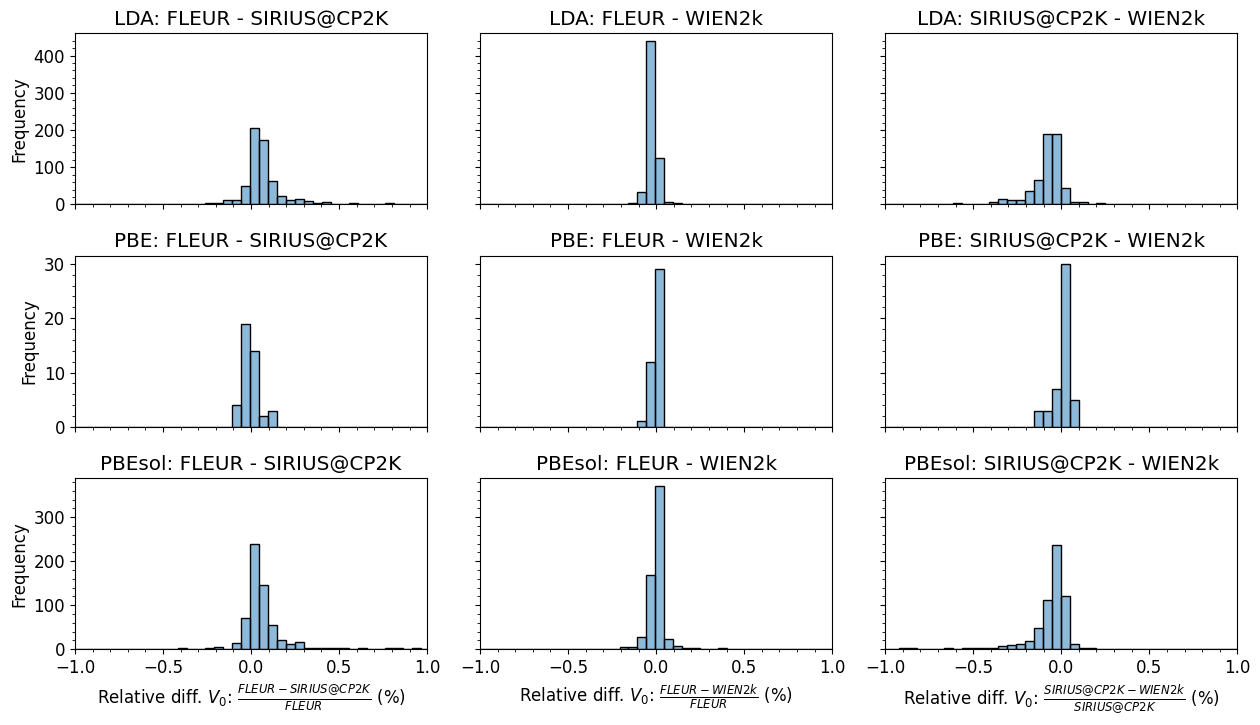

In [31]:
UNARIES_OXIDES = 'oxides'

unaries_oxides_data = {
    'unaries': df_code_differences_unaries,
    'oxides': df_code_differences_oxides
}


# Define the functionals and code pairs
functionals = ['lda', 'pbe', 'pbesol']
functionals_mapping = {'lda': 'LDA', 'pbe': 'PBE', 'pbesol': 'PBEsol'}
code_pairs = [
    'fleur - sirius-cp2k', 'fleur - wien2k', 'sirius-cp2k - wien2k'
]
code_pairs_mapping = {
    'fleur - sirius-cp2k': 'FLEUR - SIRIUS@CP2K',
    'fleur - wien2k': 'FLEUR - WIEN2k',
    'sirius-cp2k - wien2k': 'SIRIUS@CP2K - WIEN2k'
}


# Create the 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 8), sharex=True, sharey='row')
plt.subplots_adjust(hspace=0.3, wspace=0.15)

for i, functional in enumerate(functionals):
    for j, pair in enumerate(code_pairs):
        # Select the data for the current functional and code pairs
        data = unaries_oxides_data[UNARIES_OXIDES][(pair, functional)]
        print(data[data.abs().gt(1).values])
        # print(data.min(), data.max())
        # Plot the histograms
        sns.histplot(data.values, bins=np.arange(-10, 10, 0.051), alpha=0.5, legend=False, ax=axes[i, j], linewidth=1)
    
        
        # Set the title and labels
        code1, code2 = code_pairs_mapping[pair].split(' - ')
        axes[i, j].set_title(f'{functionals_mapping[functional]}: {code_pairs_mapping[pair]}')
        axes[i, j].set_xlabel(f'Relative diff. $V_0$: $\\frac{{{code1} - {code2}}}{{{code1}}}$ (%)')

        axes[i, j].set_ylabel('Frequency')
        axes[i, j].set_xlim(-1, 1)
        axes[i, j].minorticks_on()
        # axes[i, j].legend()


# plt.legend()
plt.savefig(f'central_volumes_{UNARIES_OXIDES}_differences_histograms_{version}.png', dpi=300, bbox_inches='tight')